In [1]:
import copy, itertools, json, os, pickle, re, sys, time, urllib

In [2]:
from ete3 import NCBITaxa
import html5lib
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import special
from scipy import signal as sig
from scipy.cluster.hierarchy import linkage, dendrogram, fclusterdata
from scipy.spatial.distance import jensenshannon, pdist, squareform, hamming
import scipy.stats as stats
import scipy.io as sio

In [3]:
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering
import scipy.cluster.hierarchy as sch

In [4]:
aa_babel = {
  "alphabet": "ARNDCQEGHILKMFPSTWYV-",
  "tri_alphabet": [
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY",
    "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER",
    "THR", "TRP", "TYR", "VAL", "GAP"
  ]
}
aa_babel["a2i"] = {a: i for i, a in enumerate(aa_babel["alphabet"])}
aa_babel["i2a"] = {i: a for i, a in enumerate(aa_babel["alphabet"])}
aa_babel["tri2a"] = dict(zip(aa_babel["tri_alphabet"], aa_babel["alphabet"]))
aa_babel["tri2i"] = {aaa: i for i, aaa in enumerate(aa_babel["tri_alphabet"])}

In [5]:
plt.style.use("default")
_fig_dir = "/home/jupyter-dylan/figures/"
_pdb_dir = "/home/jupyter-dylan/data/PDBs/"
_src_dir = "/home/jupyter-dylan/data/BLAT_ECOLX/"
ncbi = NCBITaxa()

________________________________________________________________________________________________________________________________________

Methods

________________________________________________________________________________________________________________________________________

In [6]:
def cce(p, q):
  """categorical cross entropy"""
  return -(p*np.log(q+1e-8)).sum((1, 2))

In [7]:
def con_mtx(f, chains, tri2a, rs, rs_ng, X_ng, diff_max):
  """confind output to contact matrix"""
  # measured contacts dataframe
  try: df = pd.read_csv(f, sep="\t", header=None, names=["kind", "i", "j", "con", "ia", "ja"]).dropna()
  except: return None
  
  # clean dataframe
  df = df[df["i"].str.contains(chains[0]) & df["j"].str.contains(chains[0])]
  df["i"] = df["i"].apply(lambda x: x.split(",")[1])
  df["j"] = df["j"].apply(lambda x: x.split(",")[1])
  df["ia"] = df["ia"].apply(lambda x: tri2a[x]).astype("str")
  df["ja"] = df["ja"].apply(lambda x: tri2a[x]).astype("str")

  # collate indices / sequences
    # reference indices / sequence
  rs_a = np.array(list("".join(rs).upper()))
  rs_i = np.arange(len(rs_a))
    # x-tal indices / sequence
  xt_ij = pd.Series(np.concatenate([df["i"].values, df["j"].values])).unique()
  if len(xt_ij) < (int(xt_ij[-1])-int(xt_ij[0])):
    xt_ij2ij = dict(zip(xt_ij, np.arange(len(xt_ij))))
    df["i"], df["j"] = df["i"].map(xt_ij2ij), df["j"].map(xt_ij2ij)
  xt_i_a = {**dict(zip(df["i"].astype("int"), df["ia"])), **dict(zip(df["j"].astype("int"), df["ja"]))}
  xt_a = "".join(list(xt_i_a.values()))
  xt_i = np.sort(np.unique(list(xt_i_a.keys())))

  # missing indices, sort, clean, map
  xt_pres = np.array(xt_i)
  xt_miss = np.setdiff1d(np.arange(np.min(xt_pres)+1), xt_pres)
  xt_i_a.update({i: "-" for i in xt_miss})
  xt_i_a = {i: xt_i_a[i] for i in np.sort(list(xt_i_a.keys()))}
  xt_a = np.array(list(xt_i_a.values()))
  xt_i = np.sort(np.array(list(xt_i_a.keys())))
  xi2ri, xia2ria = map_idx(xt_a, xt_i, xt_miss, rs_a, rs_i, diff_max)
    # additional missing indices
  if len(xi2ri) < len(X_ng):
    xt_miss = np.setdiff1d(np.arange(np.max([np.max(xt_i), np.max(rs_i)])+1), xt_pres)
    xt_i_a.update({i: "-" for i in xt_miss})
    xt_i_a = {i: xt_i_a[i] for i in np.sort(list(xt_i_a.keys()))}
    xt_a = np.array(list(xt_i_a.values()))
    xt_i = np.sort(np.array(list(xt_i_a.keys())))
    xi2ri, xia2ria = map_idx(xt_a, xt_i, xt_miss, rs_a, rs_i, diff_max)
    
  # measured contacts
  con = np.zeros((len(rs_a), len(rs_a)))
  df["i"], df["j"] = df["i"].astype("int").map(xi2ri), df["j"].astype("int").map(xi2ri)
  df = df[df["i"].notnull() & df["j"].notnull()]
  df["con"] = df["con"].astype("float")  
  for i, j, val in zip(df["i"], df["j"], df["con"]):
    con[int(i), int(j)] += val
    con[int(j), int(i)] += val

  # collect
  return {"xs": pd.Series(list(xia2ria.keys())).apply(lambda x: x[-1]).values, "con": con}

In [388]:
def contact_AUC(pred, meas, thresh=0.01):
  """# pred. contacts vs. % correct wrt "thresh" CON-FIND score"""
  # ensure comparison validity
  assert pred.shape == meas.shape, "shape mismatch"
  # evaluated i, j indices greater than 6 aa 1-D distance
  eval_idx = np.triu_indices_from(meas, 6)
  # extract contacts at relevant indices
  pred_, meas_ = pred[eval_idx], meas[eval_idx] 
  # top "L" predicted contact bins
  L = (np.linspace(0.1, 1.0, 10)*len(meas)).astype("int")
  sort_idx = np.argsort(pred_)[::-1]
  return np.mean([(meas_[sort_idx[:l]]>thresh).mean() for l in L])

In [8]:
def make_msa(seqs, a2i, gap=.5, Neff=.8):
  """construct Multiple Sequence Alignment (MSA)"""
  raw = np.array([[a2i[a] for a in seq] for seq in seqs])  
  non_gap = np.where(np.mean((raw==a2i["-"]).astype(np.float), 0)<gap)[0]
  # non-gapped columns, raw msa, effective sequence weights
  return {
    "X_ng": non_gap,
    "X": np.eye(len(a2i))[raw],
    # calculated wrt "clean" indices
    "W": 1.0/np.sum(1.0*((1.0-squareform(pdist(raw[:, non_gap], "hamming")))>=Neff), -1)
  }

In [9]:
def make_qa_msa(seqs, a2i):
  """construct Quality Annotation (MSA)"""
  raw = np.array([[a2i[a] for a in seq] for seq in seqs])  
  return np.eye(len(a2i))[np.array([[a2i[a] for a in seq] for seq in seqs])]

In [10]:
def map_idx(za, zi, missing, ra, ri, diff_max):
  """map a.a. (za) & indices (zi) to reference (ra, ri)"""

  def _hamm(length, ra_tmp, za_tmp):
    """hamming distance"""
    weights = np.ones(length)
    za_missing = np.where(za_tmp == "-")[0]
    if len(za_missing) > len(za_tmp)/2: return np.inf
    weights[za_missing] = 1e-7
    return int(length*hamming(ra_tmp, za_tmp, weights))

  # z subset r
  if len(za) < len(ra):
    l, L = len(za), len(ra)
    for idx in np.arange(L):
      x, y = idx, idx+l
      ra_tmp, ri_tmp = ra[x:y], ri[x:y]
      length = len(ra_tmp)
      if length < diff_max: break
      za_tmp, zi_tmp = za[:length], zi[:length]
      if _hamm(length, ra_tmp, za_tmp) <= diff_max:
        zi2ri, zia2ria = map_z2r(zi_tmp, ri_tmp, za_tmp, ra_tmp); break
  # r subset z
  else: # (len(za) > len(ra)) or (len(za) == len(ra))
    l, L = len(ra), len(za)
    for idx in np.arange(L):
      x, y = idx, idx+l
      za_tmp, zi_tmp = za[x:y], zi[x:y]
      length = len(za_tmp)
      if length < diff_max: break
      ra_tmp, ri_tmp = ra[:length], ri[:length]
      if _hamm(length, ra_tmp, za_tmp) <= diff_max:
        zi2ri, zia2ria = map_z2r(zi_tmp, ri_tmp, za_tmp, ra_tmp); break
  # ensure validity
  try: return zi2ri, zia2ria
  except: assert False, "\nra='"+"".join(ra)+"'\nza='"+"".join(za)+"'"

In [11]:
def map_z2r(zi_tmp, ri_tmp, za_tmp, ra_tmp):
  """map seq to ref"""
  zia = [str(i)+a for i, a in zip(zi_tmp, za_tmp)]
  ria = [str(i)+a for i, a in zip(ri_tmp, ra_tmp)]
  return dict(zip(zi_tmp, ri_tmp)), dict(zip(zia, ria))

In [12]:
def parse_af(fname, alphabet, h_count=0, rs=""):
  """clean / parse an alignment file to headers & sequences"""
  # define, open
  P = {"h": [], "s": []}
  with open(fname, "r") as lines:
    # parse
    for l, L in enumerate(lines):
      L = L.rstrip()
      try:
        # header
        if L.startswith(">"):
          h_count += 1
          P["h"].append(L[1:])
          P["s"].append([])
        # sequence
        else: P["s"][-1].append("".join([l for l in L if l in alphabet]))
        if h_count == 1 and l > 0: rs += L
      except: continue
    # collate, indices w/ length == mode lengths
    seqs = np.array(["".join(s) for s in P["s"]])
    seq_lengths = np.array([len(s) for s in seqs])
    idx = np.where(seq_lengths == stats.mode(seq_lengths)[0][0])[0]
    # collate
    return {
      # headers, sequences
      "h": np.array(P["h"])[idx], "s": seqs[idx],
      # ref. seq., non_gapped ref. seq.
      "rs": np.array(list(rs)),
      "rs_ng": np.array([i for i, l in enumerate(rs) if l in alphabet])
    }

________________________________________________________________________________________________________________________________________

- dissect DeepSeq MSA

________________________________________________________________________________________________________________________________________

In [13]:
# %%bash
# # alignment to filtered alignments
# for id in 50 55 60 65 70 75 80 85 90 95 100
# do
#   /home/UNICLUST/hh-suite/build/bin/hhfilter -i /home/jupyter-dylan/data/BLAT_ECOLX/BLAT_ECOLX_1_b0.5.a2m -maxseq 10000000 -id ${id} -cov 80 -o /home/jupyter-dylan/data/BLAT_ECOLX/BLAT_ECOLX_1_b0.5.i${id}c80.a2m
#   wait
# done

In [14]:
# # check
# !wc -l {_src_dir+"*a2m"}

________________________________________________________________________________________________________________________________________

- parse alignment

________________________________________________________________________________________________________________________________________

In [367]:
# alignment file
# af = "BLAT_ECOLX_1_b0.5.i90c80.a2m"
# af = "BLAT_ECOLX_1_b0.5.i100c80.a2m"
af = "BLAT_ECOLX_TEM1.i90c80.1e-20.a3m"
# af = "BLAT_ECOLX_TEM1.i100c80.1e-20.a3m"
paf = parse_af(_src_dir+af, aa_babel["alphabet"])

________________________________________________________________________________________________________________________________________

- high quality beta lactamase annotations
- parse phylogeny
- align to given MSA via HMMER

________________________________________________________________________________________________________________________________________

In [16]:
# # read in, clean
# annot = pd.concat([
#   pd.read_html("http://bldb.eu/BLDB.php?prot=A")[1],
#   pd.read_html("http://bldb.eu/BLDB.php?prot=B1")[1],
#   pd.read_html("http://bldb.eu/BLDB.php?prot=B2")[1],
#   pd.read_html("http://bldb.eu/BLDB.php?prot=B3")[1],
#   pd.read_html("http://bldb.eu/BLDB.php?prot=C")[1],
#   pd.read_html("http://bldb.eu/BLDB.php?prot=D")[1]
# ], axis=0)
# annot_cols = dict(zip(
#   ["Amblerclass", "Proteinname", "GenBankID", "Functionalinformation", "Natural (N) orAcquired (A)"],
#   ["ambler_class", "prot", "genbank", "fcn", "src"]
# ))
# annot = annot.rename(columns=annot_cols)[list(annot_cols.values())]
# annot = annot[~(annot["genbank"].isna() | annot["fcn"].isna() | annot["src"].isna())]
# annot = annot[annot["genbank"].apply(lambda x: (len(x) == 8) and (x != "Assigned"))]
# annot = annot[annot["ambler_class"].apply(lambda x: x in ["A", "B1", "B2", "B3", "C", "D"])]
# annot = annot[~annot["prot"].str.contains("\*")]
# annot.reset_index(drop=True, inplace=True)

In [17]:
# # annotate taxonomy
# annot_sp = []
# for x in annot["src"].astype("str").values:
#   if (x[0] != "A") and ("N" in x):
# #     annot_sp.append(x[3:].lstrip("*").rstrip(")"))
#     annot_sp.append(" ".join(x[3:].lstrip("*").rstrip(")").split(" ")[:2]))
# print("\n".join(np.unique(annot_sp)))

Achromobacter xylosoxidans
Acidaminococcus fermentans
Acinetobacter baumannii
Acinetobacter bereziniae
Acinetobacter calcoaceticus
Acinetobacter courvalinii
Acinetobacter haemolyticus
Acinetobacter johnsonii
Acinetobacter lwoffii
Acinetobacter nosocomialis
Acinetobacter oleivorans
Acinetobacter pittii
Acinetobacter radioresistens
Acinetobacter schindleri
Acinetobacter sp.
Acinetobacter tandoii
Atlantibacter hermannii
Bacteroides cellulosilyticus
Bacteroides fragilis
Bradyrhizobium diazoefficiens
Burkholderia cenocepacia
Burkholderia oklahomensis
Burkholderia pseudomallei
Burkholderia sp.
Burkholderia thailandensis
Burkholderia vietnamiensis
Capnocytophaga sputigena
Carnobacterium divergens
Chromobacterium haemolyticum
Chryseobacterium gleum
Chryseobacterium indologenes
Citrobacter gillenii
Citrobacter koseri
Citrobacter sedlakii
Desulfovibrio desulfuricans
Elizabethkingia anophelis
Elizabethkingia meningoseptica
Empedobacter brevis
Enterobacter asburiae
Enterobacter cloacae
Enterobacte

"taxID_map.txt" created from `https://www.ncbi.nlm.nih.gov/Taxonomy/TaxIdentifier/tax_identifier.cgi` using above cell output

In [304]:
# # mapping
# lineage = ["phylo_"+x for x in ["life", "domain", "kingdom", "phylum", "class", "order", "family", "genus"]]#, "species"]]
# taxID_map = pd.read_csv(_src_dir+"taxID_map.txt", sep="\t")
# taxID_map = dict(zip(taxID_map[taxID_map["code"] != 3]["name"], taxID_map[taxID_map["code"] == 1]["taxid"].astype("int")))

In [305]:
# # initialize
# taxa = {x: [] for x in lineage}
# # assign
# for src in annot["src"].values:
#   # acquired
#   if src[0] == "A":
#     for x in lineage: taxa[x].append("plasmid")
#   # natural
#   else:
#     src = " ".join(src[3:].lstrip("*").rstrip(")").split(" ")[:2])
#     try:
#       src_lin = ncbi.translate_to_names(ncbi.get_lineage(taxID_map[src]))
#       if len(src_lin) < 8:
#         for x in lineage: taxa[x].append(".")
#       else:
#         for x, y in zip(lineage, src_lin[1:9]): taxa[x].append(y)
#     except:
#       for x in lineage: taxa[x].append(".")

In [368]:
# # quality annotations
# qa = pd.concat([annot, pd.DataFrame(taxa)], 1)

In [307]:
# %%time
# # compile beta lactamase FASTAs
# bldb_fa = ""
# for i, (c, p) in enumerate(zip(qa["ambler_class"].values, qa["prot"].values)):
#   try:
#     prot_fa = urllib.request.urlopen("http://bldb.eu/seq_prot/"+c+"-"+p+"-prot.fasta").readlines()
#     prot_fa = [str(x).lstrip("b'>").rstrip("\\n'") for x in prot_fa]
#     p_seq = "".join([str(x).lstrip("b'") for x in prot_fa[1:]])
#     bldb_fa += ">"+p+"\n"+p_seq+"\n"
#   except:
#     print(i, c, p)

373 A KPC-55
374 A KPC-57
819 B1 IMP-81
925 B1 VIM-70
1420 D OXA-897
1421 D OXA-898
CPU times: user 1.78 s, sys: 334 ms, total: 2.11 s
Wall time: 3min 44s


In [308]:
# # save compiled FASTA
# with open(_src_dir+"bldb_seqs.fa", "w") as f: f.write(bldb_fa)

________________________________________________________________________________________________________________________________________

- align beta lactamase database sequences with given MSA
- parse annotations & sequences
- collate MSA

________________________________________________________________________________________________________________________________________

In [370]:
# # align db to MSA
# !cat {_src_dir+af} | sed 's/[a-z]//g' > {_src_dir+af+".fas"}
# !hmmbuild --amino --fragthresh 0 --symfrac 0 {_src_dir+af+".hmm"} {_src_dir+af+".fas"}
# !hmmsearch -o /dev/null --noali --notextw --incT 27 -T 27 -A {_src_dir+af+".sto"} {_src_dir+af+".hmm"} {_src_dir+"bldb_seqs.fa"}
# !perl /home/jupyter-dylan/scripts/s2f.pl {_src_dir+af+".sto"} {_src_dir+af+".sto.fas"}

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.1b2 (February 2015); http://hmmer.org/
# Copyright (C) 2015 Howard Hughes Medical Institute.
# Freely distributed under the GNU General Public License (GPLv3).
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             /home/jupyter-dylan/data/BLAT_ECOLX/BLAT_ECOLX_TEM1.i90c80.1e-20.a3m.fas
# output HMM file:                  /home/jupyter-dylan/data/BLAT_ECOLX/BLAT_ECOLX_TEM1.i90c80.1e-20.a3m.hmm
# input alignment is asserted as:   protein
# sym fraction for model structure: 0.000
# seq called frag if L <= x*alen:   0.000
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     BLAT_ECOLX_TEM1.i90c80.1e-20.a3m  7380   263   263    10.81  0.590 

# CPU time: 0.33u 0.02s 00:00:00.35 Elaps

In [371]:
# # HHblits generated MSA only
#   # functions / UniProt IDs
# fcns = pd.Series(paf["h"]).apply(lambda x: " ".join(x.split("|")[-1].split(" ")[1:]).split("OS=")[0].rstrip(" "))
#   # upids = pd.Series(paf["h"]).apply(lambda x: x.split("|")[1])
# upids = pd.concat([pd.Series([paf["h"][0].split("/")[0]]), pd.Series(paf["h"][1:]).apply(lambda x: x.split("|")[1])])

In [372]:
# quality sequences / annotations from BLDB
qual_seqs = parse_af(_src_dir+af+".sto.fas", aa_babel["alphabet"])
qual_hs = dict(zip(pd.Series(qual_seqs["h"]).apply(lambda x: x.split("/")[0]), qual_seqs["s"]))
qa_ok = qa[qa["prot"].apply(lambda x: x in qual_hs.keys())].copy()
print(f"# qual seqs: {len(qa_ok)}")

# qual seqs: 734


In [373]:
%%time
# multiple sequence alignment
msa = make_msa(paf["s"], aa_babel["a2i"])
qa_msa = make_qa_msa(np.array([qual_hs[h] for h in qa_ok["prot"]]), aa_babel["a2i"])

CPU times: user 4.14 s, sys: 592 ms, total: 4.73 s
Wall time: 4.74 s


________________________________________________________________________________________________________________________________________

- Beta Lactamase TEM-1 structural variability
- BLDB annotated, valid DOI, WT or missense of WT
- conFind --> collect ensemble

________________________________________________________________________________________________________________________________________

In [374]:
bldb_pdb = pd.read_html("http://bldb.eu/S-BLDB.php")[1]
tem1_pdb = bldb_pdb[(bldb_pdb["Proteinname"] == "TEM-1") & (bldb_pdb["DOI"].notna())].reset_index(drop=True)

In [34]:
# # BLDB TEM-1 PDB --> BLDB TEM-1 contacts
# for x in tem1_pdb["PDBcode"].values:
#   !wget {"https://files.rcsb.org/view/"+x+".pdb"}
#   !mv {"/home/jupyter-dylan/"+x+".pdb"} {_pdb_dir+x+".pdb"}
#   !/home/jupyter-dylan/tools/confind --rLib /home/jupyter-dylan/rotlibs --p {_pdb_dir+x+".pdb"} --o {_src_dir+x+".con.txt"}

In [375]:
# custom ignore list
_pdb_ignore = [
  "2V1Z", # directed evolution engineered TEM-1 variant
  "2V20", # reengineered variant
  "3TOI", # cyclic truncation / optimization TEM-1 variant
  "4RX2", # fusion insertion
  "4ZJ1", "4ZJ2", "4ZJ3" # noncanonical amino acid mutations  
]

In [376]:
# all TEM-1 contacts
tem1_con = {}
for pdb in tem1_pdb["PDBcode"].values:
  if pdb not in _pdb_ignore:
    tem1_con.update({pdb: con_mtx(_src_dir+pdb+".con.txt", ("A"), aa_babel["tri2a"], paf["rs"], paf["rs_ng"], msa["X_ng"], 20)})

________________________________________________________________________________________________________________________________________

- source DMS data
- DeepSeq DMS data & predictions
- DMS sequences

________________________________________________________________________________________________________________________________________

In [377]:
# read in
meas_data_cols = [
  "muts",
  "R_amp_r1_0", "R_amp_r1_10", "R_amp_r1_39", "R_amp_r1_156", "R_amp_r1_625", "R_amp_r1_2500",
  "R_amp_r1_-", "R_amp_r2_-",
  "R_amp_r2_0", "R_amp_r2_39", "R_amp_r2_156", "R_amp_r2_625", "R_amp_r2_2500"
]
meas_data = pd.read_excel(_src_dir+"amp_fitness.xlsx", skiprows=2, names=meas_data_cols)
cefo_data = pd.read_excel(_src_dir+"cefo_fitness.xlsx", names=["muts", "R_cefo"])
meas_data = pd.concat([meas_data, cefo_data[[c for c in cefo_data.columns if "R_cefo" in c]]], 1)
# average fitnes / mutant index / amino acid
meas_data["R_amp_avg_39"] = meas_data[["R_amp_r1_39", "R_amp_r2_39"]].mean(1)
meas_data["R_amp_avg_156"] = meas_data[["R_amp_r1_156", "R_amp_r2_156"]].mean(1)
meas_data["R_amp_avg_625"] = meas_data[["R_amp_r1_625", "R_amp_r2_625"]].mean(1)
meas_data["R_amp_avg_2500"] = meas_data[["R_amp_r1_2500", "R_amp_r2_2500"]].mean(1)
meas_data["idx"] = np.arange(len(meas_data)) // 19
meas_data["muts_idx_aa"] = [(i, idx, j) for i, idx, j in zip(
  meas_data["muts"].apply(lambda x: aa_babel["a2i"][x[0]]),
  meas_data["idx"],
  meas_data["muts"].apply(lambda x: aa_babel["a2i"][x[-1]])
)]

In [378]:
# read in
ds_data = np.load("/home/jupyter-dylan/data/BLAT_ECOLX/ds_supp.npy", allow_pickle=True).item()[2]["BLAT_ECOLX_Ranganathan2015"]
ds_data_cols = {
  "mutant": "muts",
  "39": "R_amp_avg_39",
  "39_1": "R_amp_r1_39",
  "39_2": "R_amp_r2_39",
  "156": "R_amp_avg_156",
  "156_1": "R_amp_r1_156",
  "156_2": "R_amp_r2_156",
  "625": "R_amp_avg_625",
  "625_1": "R_amp_r1_625",
  "625_2": "R_amp_r2_625",
  "2500": "R_amp_avg_2500",
  "2500_1": "R_amp_r1_2500",
  "2500_2": "R_amp_r2_2500",
  "cefotaxime": "R_cefo",
  "mutation_effect_prediction_independent": "ds_sw",
  "mutation_effect_prediction_pairwise": "ds_pw",
  "mutation_effect_prediction_vae_ensemble": "ds_vEns",
  "mutation_effect_prediction_vae_1": "ds_v1",
  "mutation_effect_prediction_vae_2": "ds_v2",
  "mutation_effect_prediction_vae_3": "ds_v3",
  "mutation_effect_prediction_vae_4": "ds_v4",
  "mutation_effect_prediction_vae_5": "ds_v5"
}
ds_data.rename(columns=ds_data_cols, inplace=True)
# mutant index / amino acid
ds_data["idx"] = np.arange(1, len(ds_data)+1) // 19
ds_data["muts_idx_aa"] = [(i, idx, j) for i, idx, j in zip(
  ds_data["muts"].apply(lambda x: aa_babel["a2i"][x[0]]),
  ds_data["idx"],
  ds_data["muts"].apply(lambda x: aa_babel["a2i"][x[-1]])
)]
# incorporate other beta-lactamase data
Palzkill = dict(zip(*np.load("/home/jupyter-dylan/data/BLAT_ECOLX/ds_supp.npy",
  allow_pickle=True).item()[2]["BLAT_ECOLX_Palzkill2012"][["mutant", "ddG_stat"]].values.T))
Tenaillon = dict(zip(*np.load("/home/jupyter-dylan/data/BLAT_ECOLX/ds_supp.npy",
  allow_pickle=True).item()[2]["BLAT_ECOLX_Tenaillon2013"][["mutant", "MIC_score"]].values.T))
Ostermeier = dict(zip(*np.load("/home/jupyter-dylan/data/BLAT_ECOLX/ds_supp.npy",
  allow_pickle=True).item()[2]["BLAT_ECOLX_Ostermeier2014"][["mutant", "linear"]].values.T))
  # for each dataset for each mutation
_tmplt = np.zeros(len(ds_data))
P2R, T2R, O2R = _tmplt.copy(), _tmplt.copy(), _tmplt.copy()
for i, m in enumerate(ds_data["muts"]):
  # Palzkill
  try: P2R[i] = Palzkill[m]
  except: P2R[i] = np.nan
  # Tenaillon
  try: T2R[i] = Tenaillon[m]
  except: T2R[i] = np.nan
  # Ostermeier
  try: O2R[i] = Ostermeier[m]
  except: O2R[i] = np.nan
# integrate
ds_data["P_amp_ddG_stat"] = P2R
ds_data["T_amox_MIC_score"] = T2R
ds_data["O_amp_linear"] = O2R

In [379]:
# template
wt = np.zeros((263, 20))
# init
  # measured
R_amp_avg_39, R_amp_avg_156, R_amp_avg_625, R_amp_avg_2500 = [wt.copy() for _ in range(4)]
R_amp_r1_39, R_amp_r1_156, R_amp_r1_625, R_amp_r1_2500 = [wt.copy() for _ in range(4)]
R_amp_r2_39, R_amp_r2_156, R_amp_r2_625, R_amp_r2_2500 = [wt.copy() for _ in range(4)]
R_cefo = wt.copy()
P_amp_ddG_stat, T_amox_MIC_score, O_amp_linear = [wt.copy() for _ in range(3)]
  # predicted
ds_sw, ds_pw, ds_v1, ds_v2, ds_v3, ds_v4, ds_v5, ds_vEns = [wt.copy()*np.nan for _ in range(8)]
# collect
  # measured
for ij, a, b, c, d, e, f, g, h, i, j, k, l, m in zip(*meas_data[[
  "muts_idx_aa",
  "R_amp_avg_39", "R_amp_avg_156", "R_amp_avg_625", "R_amp_avg_2500",
  "R_amp_r1_39", "R_amp_r1_156", "R_amp_r1_625", "R_amp_r1_2500",
  "R_amp_r2_39", "R_amp_r2_156", "R_amp_r2_625", "R_amp_r2_2500",
  "R_cefo"
]].values.T):
  R_amp_avg_39[ij[1], ij[2]] = a
  R_amp_avg_156[ij[1], ij[2]] = b
  R_amp_avg_625[ij[1], ij[2]] = c
  R_amp_avg_2500[ij[1], ij[2]] = d
  R_amp_r1_39[ij[1], ij[2]] = e
  R_amp_r1_156[ij[1], ij[2]] = f
  R_amp_r1_625[ij[1], ij[2]] = g
  R_amp_r1_2500[ij[1], ij[2]] = h
  R_amp_r2_39[ij[1], ij[2]] = i
  R_amp_r2_156[ij[1], ij[2]] = j
  R_amp_r2_625[ij[1], ij[2]] = k
  R_amp_r2_2500[ij[1], ij[2]] = l
  R_cefo[ij[1], ij[2]] = m
  # predicted
for ij, a, b, c, d, e, f, g, h, i, j, k in zip(*ds_data[[
  "muts_idx_aa",
  "ds_sw", "ds_pw", "ds_v1", "ds_v2", "ds_v3", "ds_v4", "ds_v5", "ds_vEns",
  "P_amp_ddG_stat", "T_amox_MIC_score", "O_amp_linear"
]].values.T):
  ds_sw[ij[1], ij[2]] = a
  ds_pw[ij[1], ij[2]] = b
  ds_v1[ij[1], ij[2]] = c
  ds_v2[ij[1], ij[2]] = d
  ds_v3[ij[1], ij[2]] = e
  ds_v4[ij[1], ij[2]] = f
  ds_v5[ij[1], ij[2]] = g
  ds_vEns[ij[1], ij[2]] = h
  P_amp_ddG_stat[ij[1], ij[2]] = i
  T_amox_MIC_score[ij[1], ij[2]] = j
  O_amp_linear[ij[1], ij[2]] = k

In [380]:
# combine
mut_data = {x: eval(x) for x in [
  "R_amp_avg_39", "R_amp_avg_156", "R_amp_avg_625", "R_amp_avg_2500",
  "R_amp_r1_39", "R_amp_r1_156", "R_amp_r1_625", "R_amp_r1_2500",
  "R_amp_r2_39", "R_amp_r2_156", "R_amp_r2_625", "R_amp_r2_2500",
  "R_cefo",
  "P_amp_ddG_stat",
  "T_amox_MIC_score",
  "O_amp_linear",
  "ds_sw", "ds_pw", "ds_v1", "ds_v2", "ds_v3", "ds_v4", "ds_v5", "ds_vEns"
]}
mut_data_df = pd.DataFrame({
  "muts": [(aa.upper()+str(idx)+str(aa_babel["i2a"][m])) for idx, aa in enumerate(paf["rs"]) for m in np.arange(20)],
  **{x: y.flatten() for x, y in mut_data.items()}
})

In [381]:
# DMS sequences
  # template
wt_oh = np.eye(21)[pd.Series(paf["rs"]).str.upper().apply(lambda x: aa_babel["a2i"][x]).values]
  # initialize
dms_seqs = []
for mut in mut_data_df["muts"]:
  mut_dX = wt_oh.copy()      
  mut_dX[int(mut[1:-1]), aa_babel["a2i"][mut[0]]] = 0
  mut_dX[int(mut[1:-1]), aa_babel["a2i"][mut[-1]]] = 1
  dms_seqs.append(mut_dX)
  # collect
dms_seqs = np.stack(dms_seqs, 0)

In [382]:
# meta data
mut_diff = dms_seqs[:, paf["rs_ng"], :][:, msa["X_ng"], :]-wt_oh[paf["rs_ng"], :][msa["X_ng"], :][None, ...]
mut_data_df["hamm_wrt_X_ng"] = np.abs(mut_diff).sum((1, 2))//2

________________________________________________________________________________________________________________________________________

- Beta Lactamase TEM-1 mutant ddG variability
- from Yang et al, 2020, PLOS ONE
- sparse experimental, full simulation

________________________________________________________________________________________________________________________________________

In [383]:
def ddg_data(x, x2y):
  """map mutant to ddG value"""
  if x[0] == x[-1]: return 0
  try: return x2y[x]
  except: np.nan

In [384]:
%%capture
# index mapping
Residue_Numbering = pd.read_csv("https://raw.githubusercontent.com/dyl4nm4rsh4ll/PLOS_BetaLactamase/master/Residue_Numbering.txt",
  header=None, sep="    ", names=["i", "ia"])
Residue_Numbering["ia"] = Residue_Numbering["ia"].map(aa_babel["tri2a"])
idx_map = dict(zip(Residue_Numbering["i"], Residue_Numbering.index))
# experimental ddG, mean / std err
Wylie_dataset = pd.read_csv("https://raw.githubusercontent.com/dyl4nm4rsh4ll/PLOS_BetaLactamase/master/Wylie_dataset.csv",
  header=0, names=["Ambler aa", "ddG(PyRosetta)", "ddG(FoldX)", "ddG(MD+FoldX)", "ddG(experiment)", "SEM(experiment)"])
Wylie_dataset = Wylie_dataset[~Wylie_dataset["Ambler aa"].str.contains("/")].rename(columns={"Ambler aa": "mut"})
Wylie_dataset["mut"] = Wylie_dataset["mut"].apply(lambda x: x[0]+str(idx_map[int(x[1:-1])])+x[-1])
ddg_mean_exp = dict(zip(*Wylie_dataset[["mut", "ddG(experiment)"]].values.T))
ddg_sem_exp = dict(zip(*Wylie_dataset[["mut", "SEM(experiment)"]].values.T))
# FoldX simulated ddG
ddg_FoldX = pd.read_csv("https://raw.githubusercontent.com/dyl4nm4rsh4ll/PLOS_BetaLactamase/master/ddg_FoldX.txt",
  header=None, sep="\t", names=["mut", "ddg_FoldX"])
ddg_FoldX["mut"] = ddg_FoldX["mut"].apply(lambda x: x[0]+str(idx_map[int(x[1:-1])])+x[-1])
ddg_fx = dict(zip(*ddg_FoldX[["mut", "ddg_FoldX"]].values.T))
# FoldX+MD simulated ddG
ddg_MD_FoldX = pd.read_csv("https://raw.githubusercontent.com/dyl4nm4rsh4ll/PLOS_BetaLactamase/master/ddg_MD%2BFoldX.csv",
  header=0, names=["mut", "ddG(MD+FoldX)", "std"])
ddg_MD_FoldX["mut"] = ddg_MD_FoldX["mut"].apply(lambda x: x[0]+str(idx_map[int(x[1:-1])])+x[-1])
ddg_mean_md_fx = dict(zip(*ddg_MD_FoldX[["mut", "ddG(MD+FoldX)"]].values.T))
ddg_sem_md_fx = dict(zip(*ddg_MD_FoldX[["mut", "std"]].values.T))
# PopMusic 
ddg_PopMusic = pd.read_csv("https://raw.githubusercontent.com/dyl4nm4rsh4ll/PLOS_BetaLactamase/master/ddg_PopMusic.csv",
  header=0, names=["i", "a", "b", "ddG(PopMusic)"])
ddg_PopMusic["mut"] = [aa_babel["tri2a"][a]+str(i)+aa_babel["tri2a"][b] for i, a, b in zip(*ddg_PopMusic[["i", "a", "b"]].values.T)]
ddg_PopMusic["mut"] = ddg_PopMusic["mut"].apply(lambda x: x[0]+str(idx_map[int(x[1:-1])])+x[-1])
ddg_pm = dict(zip(*ddg_PopMusic[["mut", "ddG(PopMusic)"]].values.T))
# PyRosetta
ddg_PyRosetta = pd.read_csv("https://raw.githubusercontent.com/dyl4nm4rsh4ll/PLOS_BetaLactamase/master/ddg_PyRosetta.csv",
  header=0, names=["mut", "ddG(PyRoseta)"])
ddg_PyRosetta["mut"] = [x+y for x, y in zip(np.repeat(list("".join(paf["rs"]).upper()), 19), ddg_PyRosetta["mut"])]
ddg_PyRosetta["mut"] = ddg_PyRosetta["mut"].apply(lambda x: x[0]+str(idx_map[int(x[1:-1])])+x[-1])
ddg_ros = dict(zip(*ddg_PyRosetta[["mut", "ddG(PyRoseta)"]].values.T))

In [385]:
# incorporate
for x in ["ddg_mean_exp", "ddg_sem_exp", "ddg_fx", "ddg_mean_md_fx", "ddg_sem_md_fx", "ddg_pm", "ddg_ros"]:
  mut_data_df[x] = mut_data_df["muts"].apply(lambda y: ddg_data(y, eval(x)))

________________________________________________________________________________________________________________________________________

- combine
- save

________________________________________________________________________________________________________________________________________

In [386]:
# collect
DATA = {
  "fcns": fcns,
  "upids": upids,
  "rs": paf["rs"],
  "rs_ng": paf["rs_ng"],
  "dX": dms_seqs,
  "dY": mut_data_df,
  "qa": qa_ok,
  "X_qa": qa_msa,
  "con": tem1_con,
  **msa
}
# check
for a, b in DATA.items():
  try: print(a, b.shape)
  except: print(a, len(b))

fcns (7356,)
upids (7356,)
rs (263,)
rs_ng (263,)
dX (5260, 263, 21)
dY (5260, 33)
qa (734, 13)
X_qa (734, 263, 21)
con 42
X_ng (257,)
X (7356, 263, 21)
W (7356,)


In [387]:
# save
print("saving: "+_src_dir+"DATA_"+af)
np.save(_src_dir+"DATA_"+af, DATA)

saving: /home/jupyter-dylan/data/BLAT_ECOLX/DATA_BLAT_ECOLX_TEM1.i90c80.1e-20.a3m


# analysis

________________________________________________________________________________________________________________________________________

structural variability

________________________________________________________________________________________________________________________________________

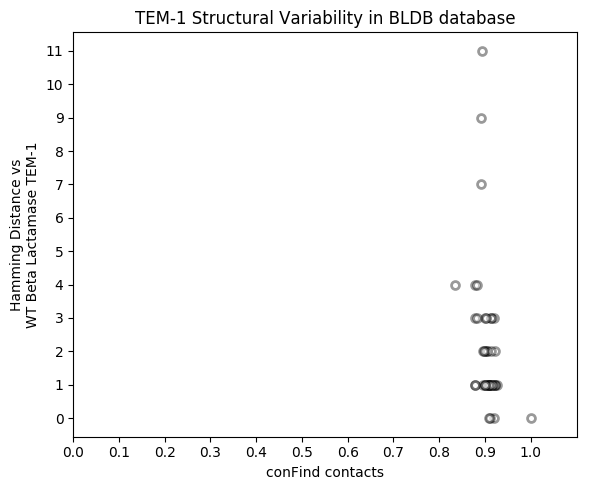

In [390]:
# data
conAUCs = pd.DataFrame(dict(zip(tem1_con.keys(), [x["con"].flatten() > 0.01 for x in tem1_con.values()]))).corr("spearman")
hammDs = np.array([int(263*hamming(tem1_con[pdb]["xs"], list("".join(paf["rs"]).upper()))) for pdb in tem1_con.keys()])
# viz
F, A = plt.subplots(1, 1, figsize=(6, 5))
A.scatter(conAUCs["1ERO"].values, hammDs, s=32, c="w", edgecolors="k", alpha=0.4, lw=2)
A.set_title("TEM-1 Structural Variability in BLDB database")
A.set_xlabel("conFind contacts")
A.set_ylabel("Hamming Distance vs\nWT Beta Lactamase TEM-1")
A.set_xlim([0, 1.1])
A.set_xticks(np.linspace(0, 1, num=11))
A.set_yticks(np.arange(12))
plt.tight_layout()
# plt.savefig(_fig_dir+"str_var1.pdf", bbox_inches="tight", frameon=False, pad_inches=0, format="pdf")
plt.show();

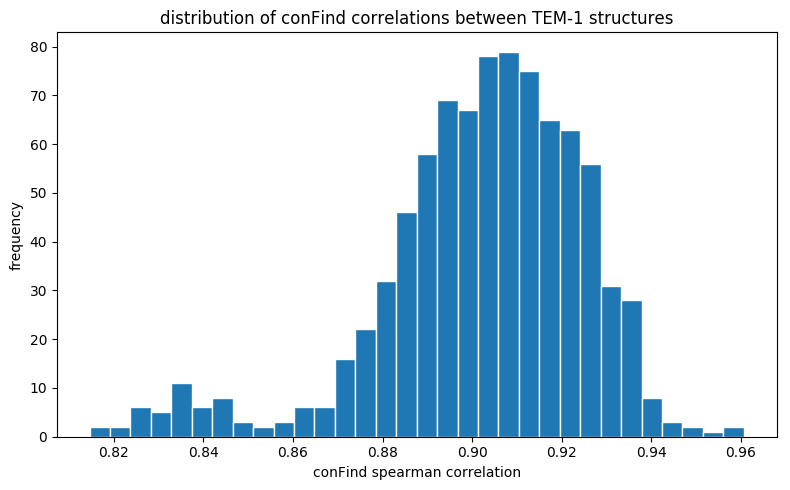

In [391]:
# viz
F, A = plt.subplots(1, 1, figsize=(8, 5))
A.hist(conAUCs.values[np.triu_indices(len(conAUCs), 1)].flatten(), bins=32, ec="w");
A.set_title("distribution of conFind correlations between TEM-1 structures")
A.set_ylabel("frequency")
A.set_xlabel("conFind spearman correlation")
plt.tight_layout()
# plt.savefig(_fig_dir+"str_var2.pdf", bbox_inches="tight", frameon=False, pad_inches=0, format="pdf")
plt.show();

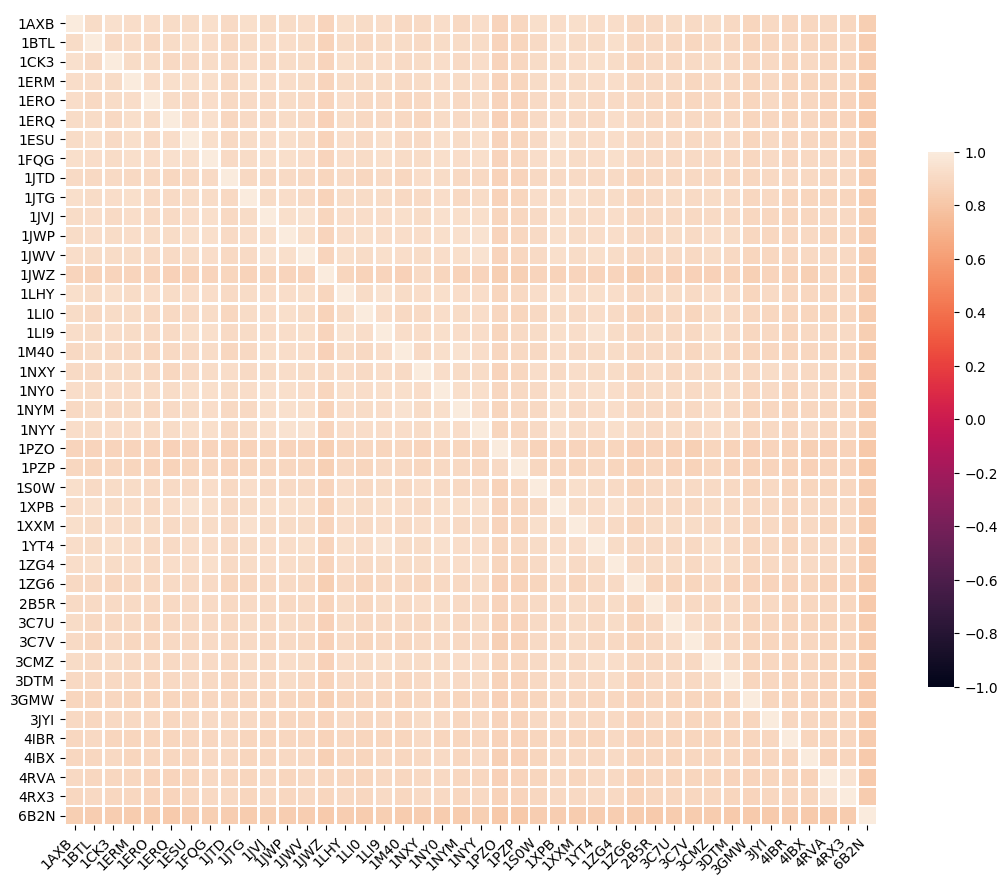

In [392]:
# viz
F, A = plt.subplots(1, 1, figsize=(11, 11))
sns.heatmap(
  conAUCs,
#   fmt=".2f", annot=True,
  vmin=-1, vmax=1, linecolor="w", linewidths=1, square=True,
  cbar_kws={"ticks": np.linspace(-1, 1, num=11), "shrink": 0.5},
  ax=A
);
A.set_xticklabels(A.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.tight_layout()
# plt.savefig(_fig_dir+"str_var3.pdf", bbox_inches="tight", frameon=False, pad_inches=0, format="pdf")
plt.show();

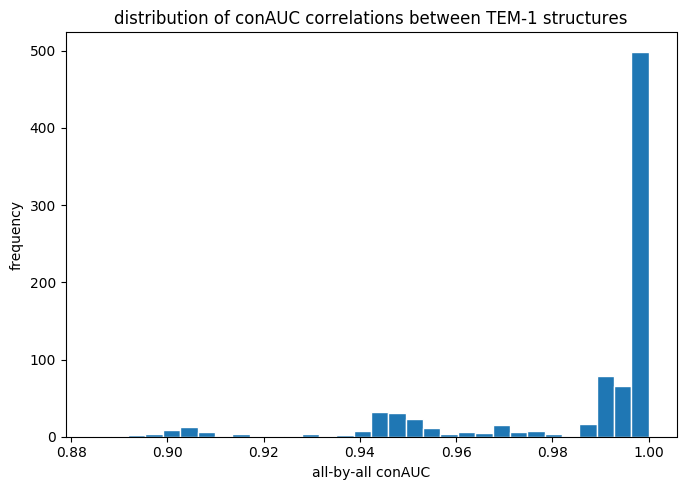

In [398]:
# data
conAUCs = np.array([contact_AUC(
    DATA["con"][x]["con"][:, DATA["rs_ng"]][DATA["rs_ng"], :][:, DATA["X_ng"]][DATA["X_ng"], :],
    DATA["con"][y]["con"][:, DATA["rs_ng"]][DATA["rs_ng"], :][:, DATA["X_ng"]][DATA["X_ng"], :]
  ) for x in DATA["con"].keys() for y in DATA["con"].keys()
]).reshape((len(DATA["con"].keys()), len(DATA["con"].keys())))
conAUCs = conAUCs[np.triu_indices(len(conAUCs), k=1)[0], np.triu_indices(len(conAUCs), k=1)[1]]
# viz
F, A = plt.subplots(1, 1, figsize=(7, 5))
A.hist(conAUCs, bins=32, ec="w");
A.set_title("distribution of conAUC correlations between TEM-1 structures")
A.set_ylabel("frequency")
A.set_xlabel("all-by-all conAUC")
plt.tight_layout()
plt.savefig(_fig_dir+"str_var4.pdf", bbox_inches="tight", frameon=False, pad_inches=0, format="pdf")
plt.show();

________________________________________________________________________________________________________________________________________

mutant variability

________________________________________________________________________________________________________________________________________

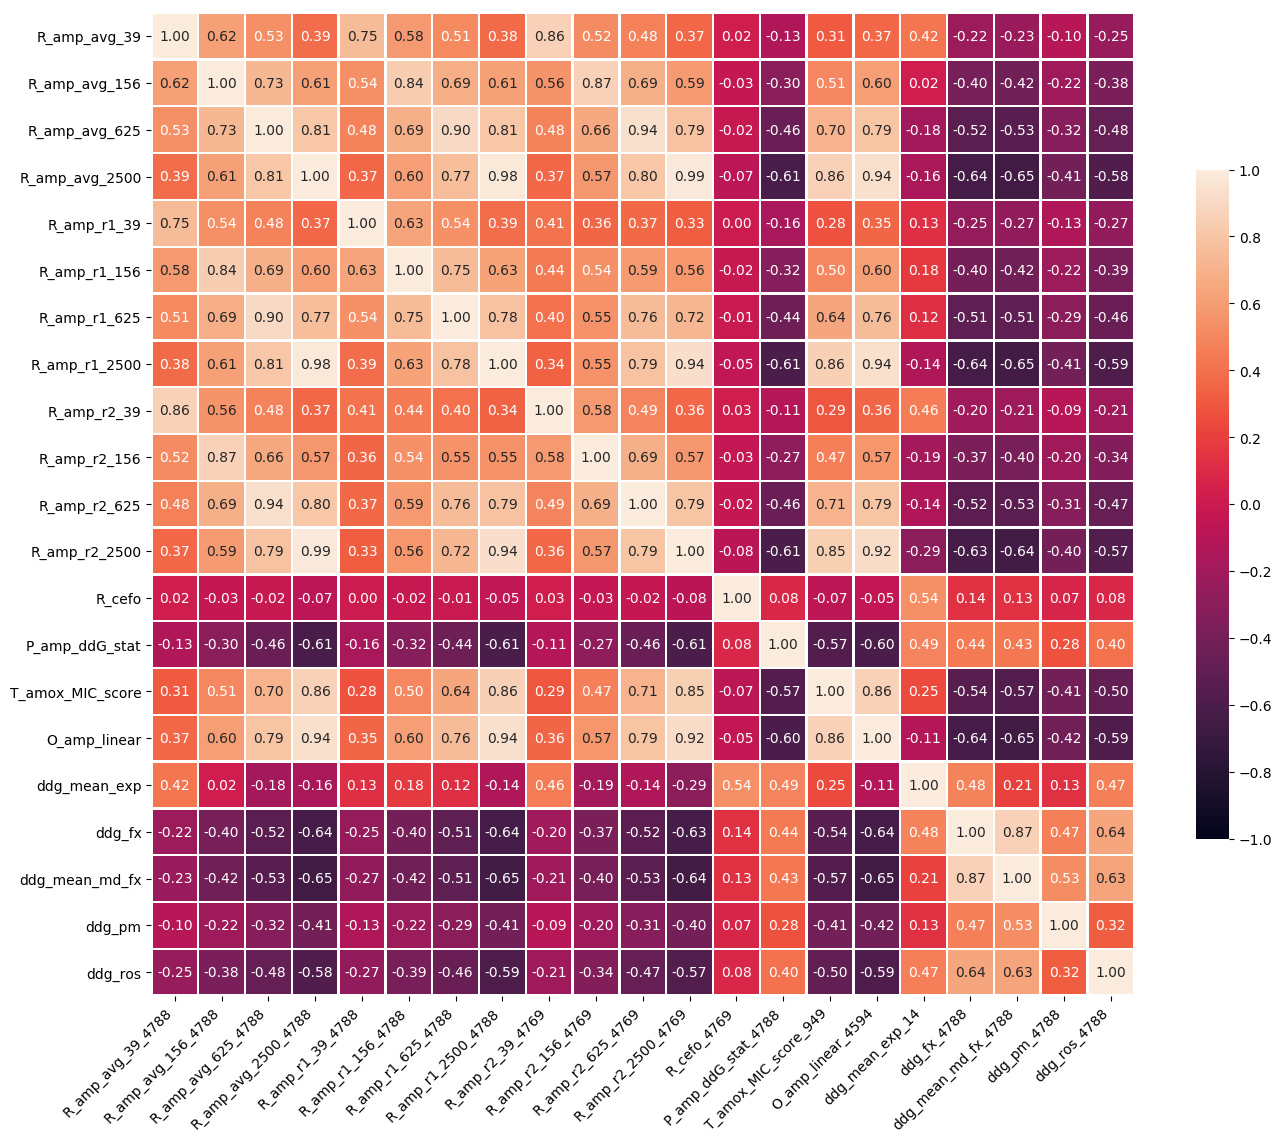

In [54]:
# context
hm_data = mut_data_df[mut_data_df["hamm_wrt_X_ng"] == 1][[
  c for c in mut_data_df.columns if all([x not in c for x in ["hamm", "sem", "ds"]])
]].corr("spearman")#.abs()
hm_data.rename(
  columns=dict(zip(
    hm_data.columns,
    [(x+"_"+str(mut_data_df[x][mut_data_df["hamm_wrt_X_ng"] == 1].notna().sum())) for x in hm_data.columns])),
  inplace=True
)
mask = np.zeros_like(hm_data)
mask[np.triu_indices_from(mask)] = True
# viz
F, A = plt.subplots(1, 1, figsize=(14, 14))
sns.heatmap(
  hm_data,
  fmt=".2f", annot=True, vmin=-1, vmax=1, linecolor="w", linewidths=1, square=True,# mask=mask,
  cbar_kws={"ticks": np.linspace(-1, 1, num=11), "shrink": 0.5},
  ax=A
);
A.set_xticklabels(A.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.tight_layout()
# plt.savefig(_fig_dir+"mut_var1.pdf", bbox_inches="tight", frameon=False, pad_inches=0, format="pdf")
plt.show();

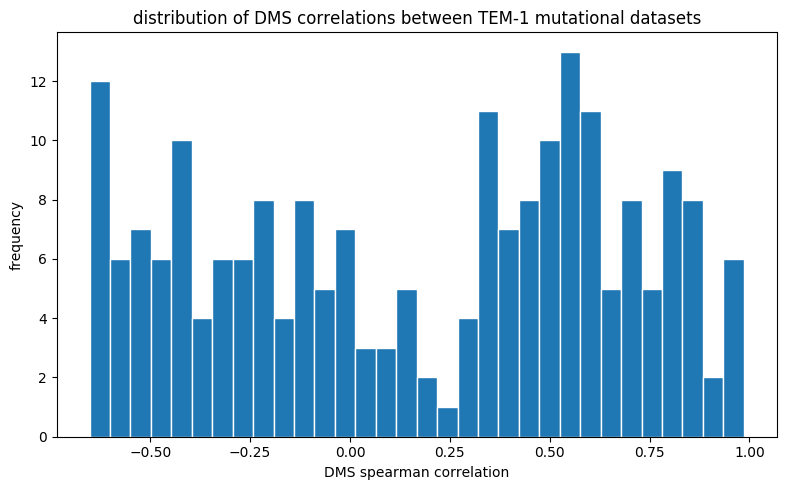

In [240]:
# viz
F, A = plt.subplots(1, 1, figsize=(8, 5))
A.hist(hm_data.values[np.triu_indices(len(hm_data), 1)].flatten(), bins=32, ec="w");
A.set_title("distribution of DMS correlations between TEM-1 mutational datasets")
A.set_ylabel("frequency")
A.set_xlabel("DMS spearman correlation")
plt.tight_layout()
# plt.savefig(_fig_dir+"mut_var2.pdf", bbox_inches="tight", frameon=False, pad_inches=0, format="pdf")
plt.show();

________________________________________________________________________________________________________________________________________

other

________________________________________________________________________________________________________________________________________